#### In this script we use a dataframe containing a series of points with different values (arbitrary units), each characterized by x and y coordinates. We don't really care about the values, we only use the dataframe to generate a 2D array and plot it as a scattered map, with new coordinates. Some points will be well isolated whereas some others will be close in one or both coordinates, and should be considered as clusters.  At that point we would like to count the number of points, distinguishing between isolated and clustered dots. We write a code using KDTree to achieve this, and compare the results with the classical KMeans algorithm.

In [31]:
#IMPORT PACKAGES:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms

%pylab inline
import numpy as np
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from scipy.sparse.linalg import spsolve

Populating the interactive namespace from numpy and matplotlib


In [32]:
data = pd.read_csv('file.txt', sep="\t")

In [33]:
data.columns = ["x", "y",'Value']
data['Value'] = data.Value.astype(float)
data['Value'] = (data['Value']-data['Value'].min())/(data['Value'].max()-data['Value'].min()) #Normalize to 1
data

,x,y,Value
0,170.199997,5411.100098,0.000000
1,170.199997,5385.100098,0.000000
2,170.199997,5359.100098,0.023210
3,170.199997,5333.100098,0.000068
4,170.199997,5307.100098,0.019881
...,...,...,...
41188,5526.200195,367.100006,0.021858
41189,5526.200195,341.100006,0.038169
41190,5526.200195,315.100006,0.000000
41191,5526.200195,289.100006,0.018899


Number of points: 43


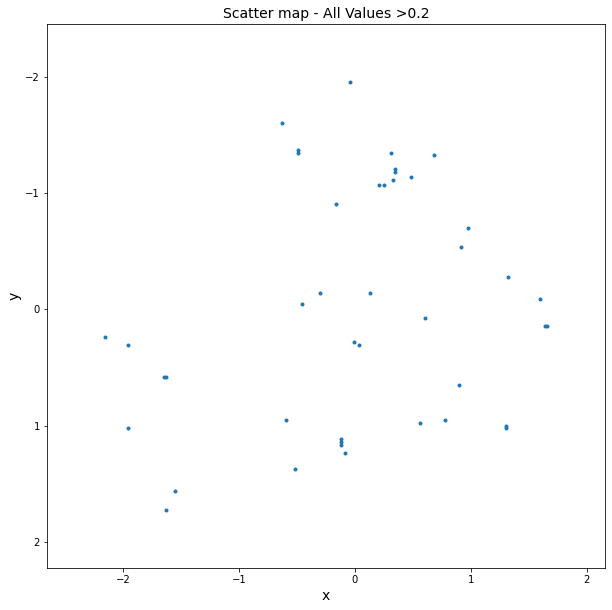

In [34]:
mappa = data.round(decimals=10).pivot('y', 'x', 'Value')

#THERE ARE MANY POINTS WITH VALUE DIFFERENT FROM 0, SO WE FILTER THE MAP BY PUTTING A THRESHOLD HERE. YOU CAN CHANGE THE 
#THRESHOLD TO HAVE MAPS WITH LESS OR MORE POINTS, AND TEST THE PERFORMANCE OF THE ALGORITHMS BELOW.

Threshold = 0.2
Value_map_binario = mappa > Threshold   #Gives a map with True if Values > Threshold and False otherwise. 
Value_map_binario = Value_map_binario.to_numpy()
     
vector_x = [] 
vector_y = []
    
for i in np.arange(Value_map_binario.shape[0]):
     for j in np.arange(Value_map_binario.shape[1]):
        if Value_map_binario[i,j] == 1:
            vector_x.append(i)
            vector_y.append(j)
        
XX = np.array([vector_x, vector_y]).T

scaler = StandardScaler()
XX1 = scaler.fit_transform(XX)

plt.figure(figsize=(10,10))
plt.plot(XX1[:,1], XX1[:,0],marker='.',linestyle='None')
#plt.ylim(max(XX1[:,0]+0.2), min(XX1[:,0]-0.2))
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
plt.xlim(min(XX1[:,1]-0.5), max(XX1[:,1]+0.5))
plt.title('Scatter map - All Values >'+ str(Threshold), fontsize = 14)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
#plt.ylim(2,1.8)
print('Number of points:', len(XX1))

## Typical  KMeans

Number of iterations: 3
Points labels: [33 18 19 30 13 15 36  4 40 32 31 25 20 38 12 16 22 35 27 23  9 11 29 37
 41 10  5  0  0  7  8  1 14 39 21  3 17  2 26  6 34 24 28]


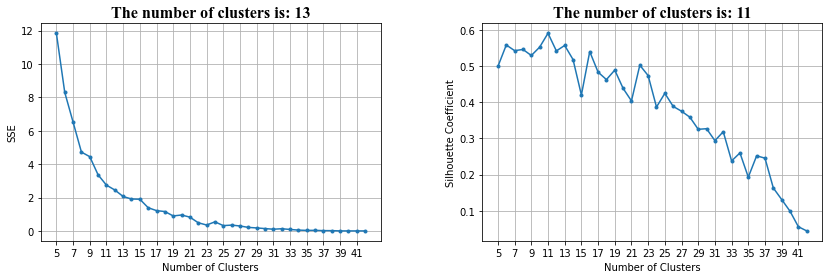

In [35]:
sse = [] #sum of squared errors
silhouette_coefficients = []
R = range(5,43)
num = []

for k in R:
    kmeans = KMeans(init='random',n_clusters=k, n_init=20, max_iter=300)
    kmeans.fit(XX1)
    sse.append(kmeans.inertia_) #for the elbow method
    score = silhouette_score(XX1, kmeans.labels_) #for the silhouette coefficient method
    silhouette_coefficients.append(score)
    num.append(k)
    
from kneed import KneeLocator
kl = KneeLocator(R, sse, curve="convex", direction="decreasing")

print('Number of iterations:',kmeans.n_iter_)
print('Points labels:', kmeans.labels_)


#PLOT THE TWO METHODS
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))
plt.subplots_adjust(wspace=0.3)
ax1.plot(R, sse, marker='.')
ax1.set_xticks(range(5, 43,2))
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("SSE")
ax1.set_title('The number of clusters is: ' + str(kl.elbow), fontweight="bold",fontname="Times New Roman",fontsize=16)
ax1.grid()
ax2.plot(R, silhouette_coefficients, marker='.')
ax2.set_xticks(range(5, 43, 2))
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Coefficient")
ax2.set_title('The number of clusters is: '+str(argmax(silhouette_coefficients)+num[0]), fontweight="bold",
              fontname="Times New Roman", fontsize=16)
ax2.grid()
#ax2.margins(x=0)
#ax2.set_xlim(2,29)

The number of clusters is: 11


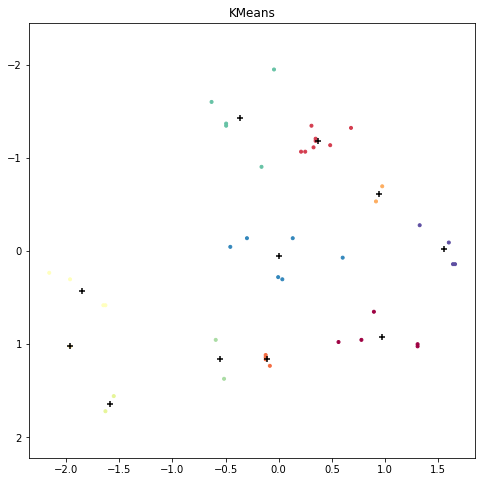

In [36]:
final = KMeans(init="random",n_clusters = argmax(silhouette_coefficients)+num[0],n_init=10, max_iter=300)
final.fit(XX1)
#print('The number of clusters is: '+str(argmax(silhouette_coefficients)+num[0]))
print('The number of clusters is: '+str(len(final.cluster_centers_)))

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(final.labels_))))
plt.figure(figsize=(8,8))
plt.scatter(XX1[:,1], XX1[:,0], c = colors[final.labels_], marker='.')
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
plt.scatter(final.cluster_centers_[:,1],final.cluster_centers_[:,0], marker='+',linestyle='None', c='k')
plt.title('KMeans');

## Custom KMeans: we set the number of clusters
#### If instead, we want KMeans to catch all points, distinguishing between insolated points and small clusters, we may achieve it trivially by setting the number of clusters that we a priori expect

Lowest SSE value: 0.07536740520253943
Clusters centers: [[-0.61388575  0.94450802]
 [-1.94941809 -0.04416355]
 [ 0.95391309  0.77809795]
 [ 1.37199278 -0.51402726]
 [-1.11325871  0.32781189]]
Number of iterations: 2


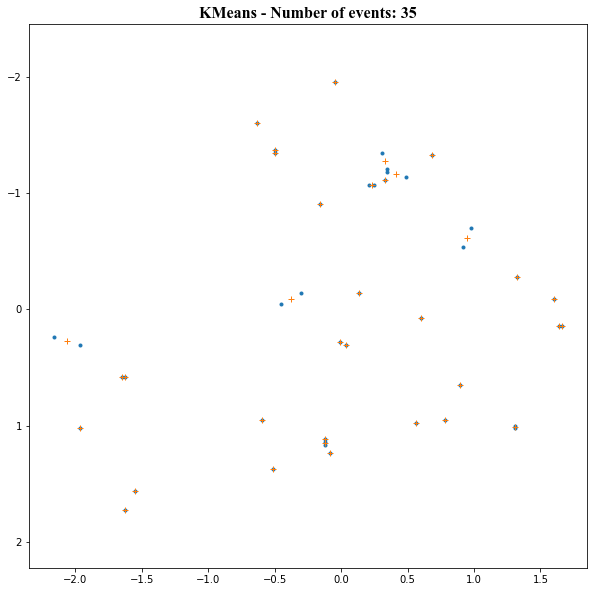

In [37]:
kmeans = KMeans(init="random", n_clusters=35, n_init=10, max_iter=300)
    
kmeans.fit(XX1)

#The lowest SSE value
print('Lowest SSE value:', kmeans.inertia_)

print('Clusters centers:',kmeans.cluster_centers_[0:5])

print('Number of iterations:',kmeans.n_iter_)

plt.figure(figsize=(10,10))
plt.plot(XX1[:,1], XX1[:,0],marker='.',linestyle='None')
plt.plot(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0], marker='+',linestyle='None')
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
#plt.ylim(2,1.8)
plt.title('KMeans - Number of events: '+str(len(kmeans.cluster_centers_)),fontweight="bold",fontname="Times New Roman",fontsize=16);

#### What we want is for the algorithm to automatically recognize all the points in order count them, and only the very close ones to be considered as clusters. One could explore modified versions of KMeans, such as KMeans Constrained, or alternative clutering algorithms, in order to achieve it. 
#### Here we propose a way of doing it by using the python KDTree function, which calculates the Euclidean distance between the list of points, and outputs an array with all the pairs of points that are close to each other, without repetitions. The good thing is that you can decide how big the distance is, to be considered “close” or not.

In [38]:
#Transform XX1 into a dataframe
XX1_df = pd.DataFrame(XX1, columns = ['y','x'])

#Use KDTree to find the points that are close to each other within a radius "dist"
from scipy.spatial import KDTree

dist = 0.05
points_tree = KDTree(XX1)
points_in_radius = points_tree.query_pairs(dist)
A = list(points_in_radius) #Shows all the pairs of points (the indices in XX1) found with KDTree

l = []; l1=[]; lsec=[]
for row in A:
    l1.extend(row)   # make a simple list with all the numbers in A
    l.append(row[0]) # make a list with the 1st elements of the pairs in A
    lsec.append(row[1]) # make a list with the 2nd elements of the pairs in A
    
l = [x for x in l if x not in lsec] #remove values in l that are also in lsec (because if a value appearing as the first element
# of the pair also appears as the second element of another pair we don't take it, since l already contains the first element
# of that other pair; and it would be a repetition)
    
l = list(dict.fromkeys(l)) #Getting rid of duplicates
l1 = list(dict.fromkeys(l1))
#l = sorted(l) #From smaller to higher
#l1 = sorted(l1)
print('Pair of points that are close to one another \033[1mA\033[0m:', A)
print('Points in A, without repetitions \033[1ml1\033[0m:', l1)
print('First elements of the A pairs, without repetitions \033[1ml\033[0m:', l)

Pair of points that are close to one another A: [(33, 35), (10, 11), (6, 7), (36, 38), (36, 37), (37, 38), (21, 22), (24, 26), (2, 3), (27, 28)]
Sorted points in A, without repetitions l1: [33, 35, 10, 11, 6, 7, 36, 38, 37, 21, 22, 24, 26, 2, 3, 27, 28]
First elements of the A pairs, without repetitions l: [33, 10, 6, 36, 21, 24, 2, 27]


In [39]:
XX2 = XX1_df[XX1_df.index.isin(l1)] #Filter XX1 with only the points indicated in l1
XX1_isolated = XX1_df[XX1_df.index.isin(l1)==False] #Filter XX1 with only the points NOT indicated in L1
XX1_isolated = np.array(XX1_isolated)
XX3 = XX1_df[XX1_df.index.isin(l)] #Filter XX1 with only the points indicated in l
XX4 = XX2.to_numpy() #Convert to numpy for plotting
XX5 = XX3.to_numpy()

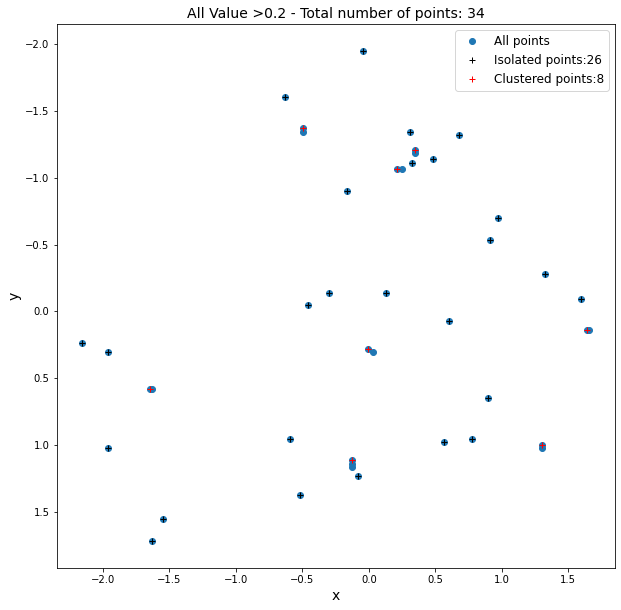

In [40]:
plt.figure(figsize=(10,10))
plt.plot(XX1[:,1], XX1[:,0],marker='o',linestyle='None',label='All points')
plt.plot(XX1_isolated[:,1], XX1_isolated[:,0],marker='+',c='k',linestyle='None',label='Isolated points:'+ str(len(XX1_isolated)))
plt.plot(XX5[:,1], XX5[:,0],marker='+',c='r',linestyle='None', label='Clustered points:'+ str(len(XX5)))
plt.ylim(max(XX1[:,0]+0.2), min(XX1[:,0]-0.2))
plt.title('All Value >'+ str(Threshold)+' - Total number of points: '+ str(len(XX1_isolated)+len(XX5)),fontsize=14);
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(fontsize=12)

#### As we see, this works for our purposes, and it has the flexibility to be optimized by changing the paramenter "dist", to consider as clustered points, those who have a smaller or larger distance among them. 